# Fake/Real News Classification
reference: https://www.kaggle.com/code/jonathanlam1014/fake-news-headlines-classification

In [23]:
import numpy as np 
import pandas as pd 

## load dataset

In [24]:
#Read Dataset
Headlines = pd.read_csv('./input/abcnews-date-text.csv', usecols =["headline_text"]).dropna()
Fake = pd.read_csv('./input/Fake.csv', usecols =["title"]).dropna()
Fake2 = pd.read_csv('./input/Fake 2.csv', usecols =["title"]).dropna()

In [25]:
#Removing duplicated headlines
Headlines = Headlines.drop_duplicates('headline_text')
Fake = Fake.drop_duplicates('title')
Fake2 = Fake2.drop_duplicates('title')

In [26]:
Fake = Fake.rename(columns={'title': 'headline_text'})
Fake2 = Fake2.rename(columns={'title': 'headline_text'})

- Headline - real(fake=0)
- Fake     - fake(fake=1)

In [27]:
Headlines['fake'] = 0
Fake['fake'] = 1
Fake2['fake'] = 1

In [28]:
# Downsize million-headlines dataset to first 50K rows
Headlines = Headlines.head(50000)
fake_headline = pd.concat([Fake, Fake2], ignore_index=True)
fake_headline = fake_headline.rename(columns={'title': 'headline_text'})
print('Training dataset contains: {} Real headlines and {} Fake headlines.'.format(len(Headlines),len(Fake)+len(Fake2)))

Training dataset contains: 50000 Real headlines and 29601 Fake headlines.


### balance dataset constructed

In [29]:
Headlines = Headlines.head(25000)
fake_headline = fake_headline.head(25000)
train = pd.concat([fake_headline, Headlines], ignore_index=True)

In [30]:
train.head()

,headline_text,fake
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1


In [31]:
%pip install gensim nltk scikit-learn

import gensim
import nltk as nl
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk_stopwords = nl.corpus.stopwords.words('english')
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
sklearn_stopwords = ENGLISH_STOP_WORDS
combined_stopwords = sklearn_stopwords.union(nltk_stopwords, gensim_stopwords)

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Note: you may need to restart the kernel to use updated packages.


### stop words

In [32]:
print('NLTK has {} stop words'.format(len(nltk_stopwords)))
print('Gensim has {} stop words'.format(len(gensim_stopwords)))
print('Sklearn has {} stop words'.format(len(sklearn_stopwords)))
print('Combined stopwords list has {} stop words'.format(len(combined_stopwords)))

NLTK has 179 stop words
Gensim has 337 stop words
Sklearn has 318 stop words
Combined stopwords list has 390 stop words


In [33]:
from nltk.stem import PorterStemmer 
porter_stemmer = PorterStemmer() 

In [34]:
train['headline_text'] = train['headline_text'].apply(lambda x: x.lower())
train['headline_text'] = train['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
train['headline_text'] = train['headline_text'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
train['headline_text'] = train['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

In [35]:
train.head()

,headline_text,fake
0,donald trump send embarrass new eve thi disturb,1
1,drunk brag trump staffer start russian collus ...,1
2,sheriff david clark becom internet joke threat...,1
3,trump obsess ha code hi websit,1
4,pope franci donald trump dure hi christma speech,1


In [36]:
# split the dataset into training and validation datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['headline_text'], train['fake'], test_size=0.2)


## Construct classification model use TF-IDF

### vectorize

In [37]:
# construct models use TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from keras.models import Sequential # type: ignore
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPooling1D, LSTM, Bidirectional, GRU # type: ignore
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.callbacks import EarlyStopping # type: ignore
from keras import regularizers

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [42]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


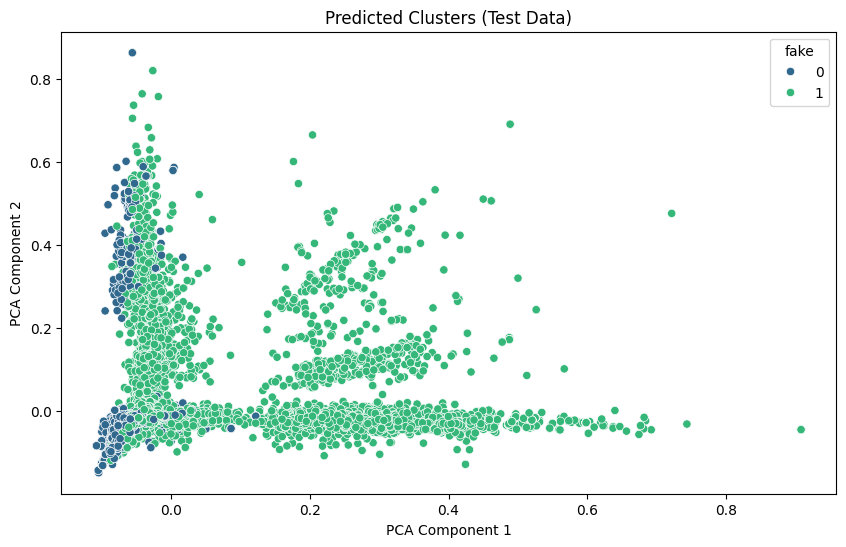

In [39]:
# visualize the classified results with labels
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=2)
train_pca = pca.fit_transform(tfidf_train)
test_pca = pca.transform(tfidf_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_pca[:,0], y=train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Predicted Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### basic models

In [40]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,modelnames, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    print('Accuracy: ', accuracy_score(predictions, y_test))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix, {}'.format(modelnames))
    plt.show()

In [41]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
svc = SVC(kernel='linear', probability=True)
knn = KNeighborsClassifier(n_jobs=-1 )
nb = MultinomialNB()
gb = GradientBoostingClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False)
lgbm = LGBMClassifier(device='gpu')

DecisionTreeClassifier()
Accuracy:  0.8462
              precision    recall  f1-score   support

           0       0.80      0.91      0.86      4966
           1       0.90      0.78      0.84      5034

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

[[4541  425]
 [1113 3921]]


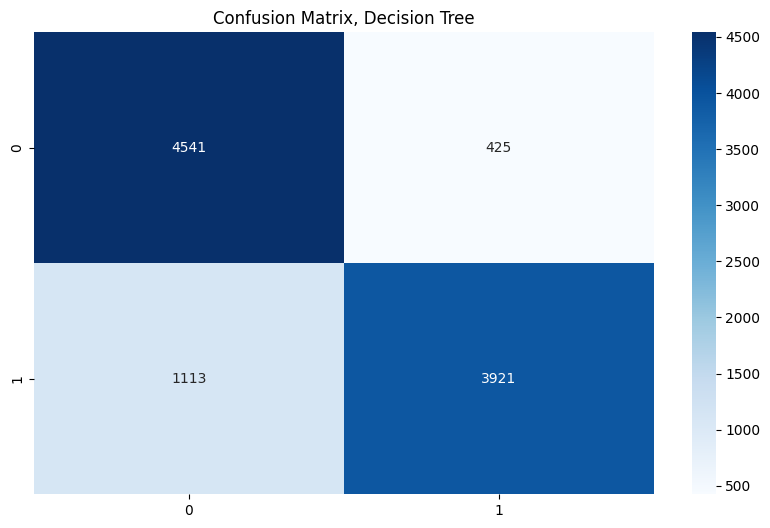

RandomForestClassifier(n_jobs=-1)
Accuracy:  0.8576
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      4966
           1       0.92      0.79      0.85      5034

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

[[4598  368]
 [1056 3978]]


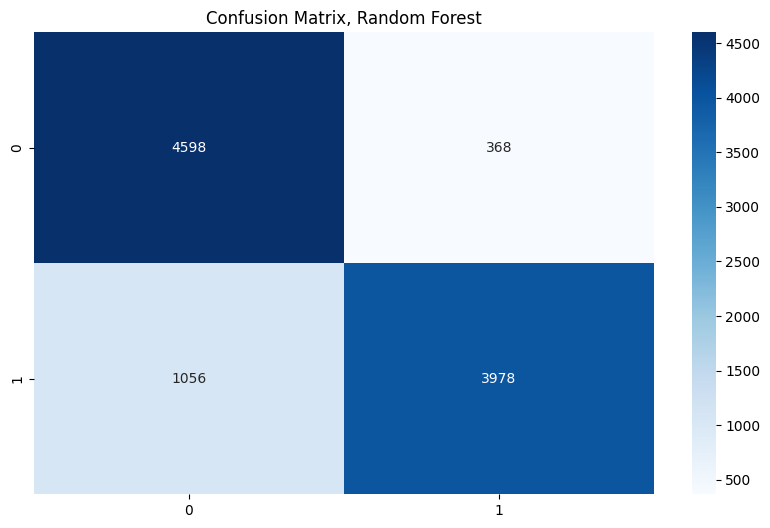

SVC(kernel='linear', probability=True)
Accuracy:  0.8574
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      4966
           1       0.92      0.78      0.85      5034

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

[[4625  341]
 [1085 3949]]


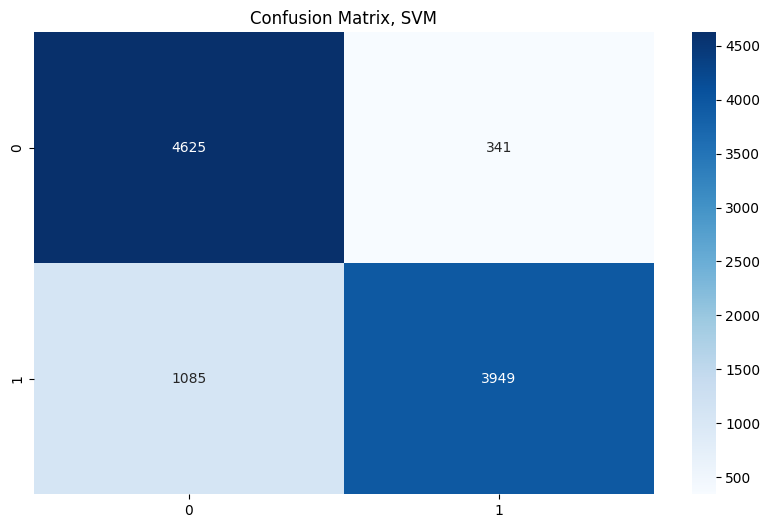

KNeighborsClassifier(n_jobs=-1)
Accuracy:  0.7581
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      4966
           1       0.75      0.78      0.76      5034

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

[[3647 1319]
 [1100 3934]]


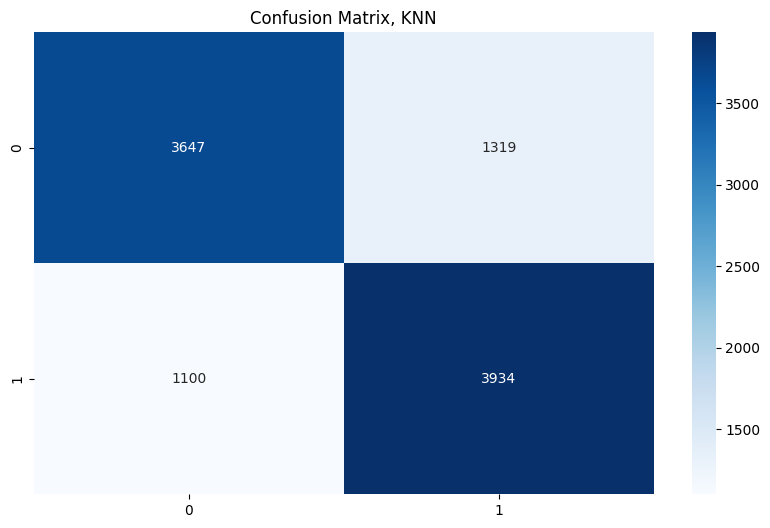

MultinomialNB()
Accuracy:  0.8512
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4966
           1       0.89      0.80      0.84      5034

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

[[4478  488]
 [1000 4034]]


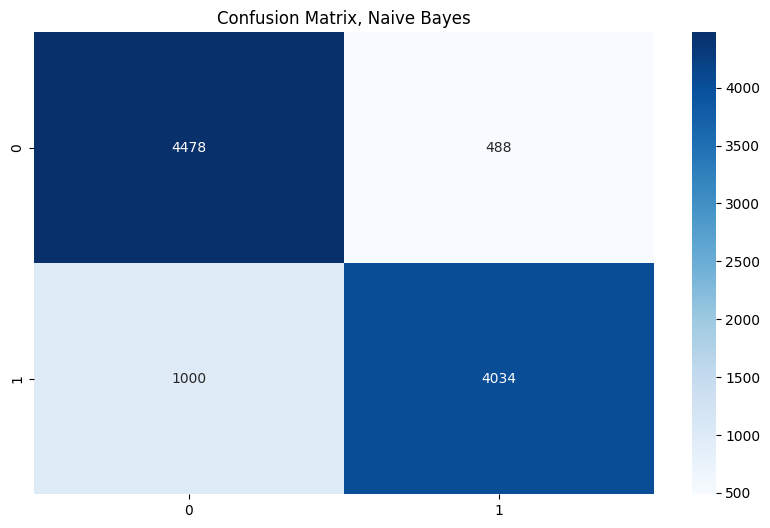

GradientBoostingClassifier()
Accuracy:  0.8035
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      4966
           1       0.97      0.63      0.76      5034

    accuracy                           0.80     10000
   macro avg       0.85      0.80      0.80     10000
weighted avg       0.85      0.80      0.80     10000

[[4872   94]
 [1871 3163]]


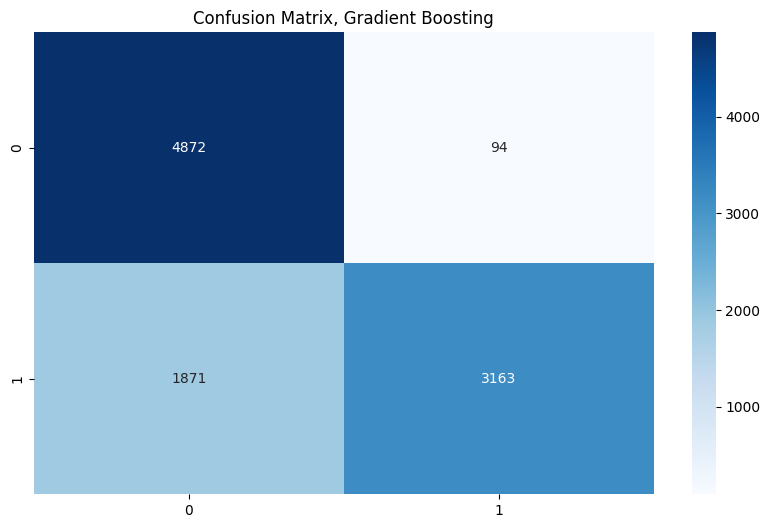

AdaBoostClassifier()


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.8207
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      4966
           1       0.95      0.68      0.79      5034

    accuracy                           0.82     10000
   macro avg       0.85      0.82      0.82     10000
weighted avg       0.85      0.82      0.82     10000

[[4797  169]
 [1624 3410]]


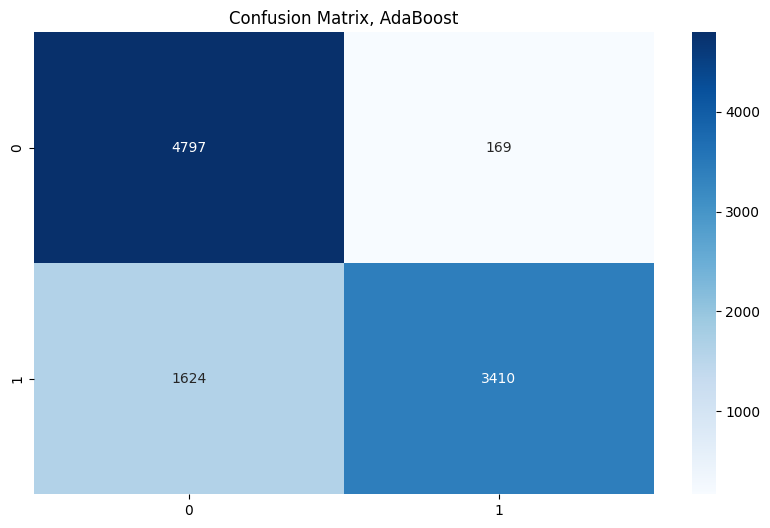

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, predictor='gpu_predictor', ...)


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c

Accuracy:  0.8569
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      4966
           1       0.95      0.76      0.84      5034

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

[[4747  219]
 [1212 3822]]


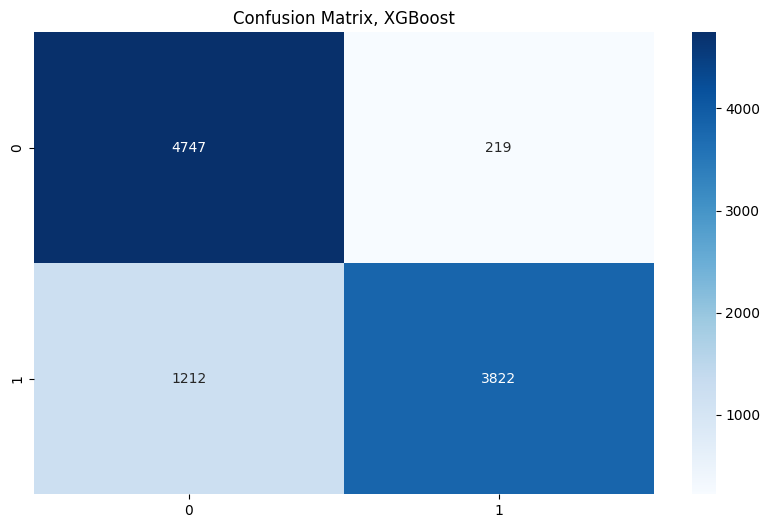

LGBMClassifier(device='gpu')
[LightGBM] [Info] Number of positive: 19966, number of negative: 20034
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 26375
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 300
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499150 -> initscore=-0.003400
[LightGBM] [Info] Start training from score -0.003400
Accuracy:  0.8593
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      4966
           1       0.94      0.77      0.85      5034

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     1

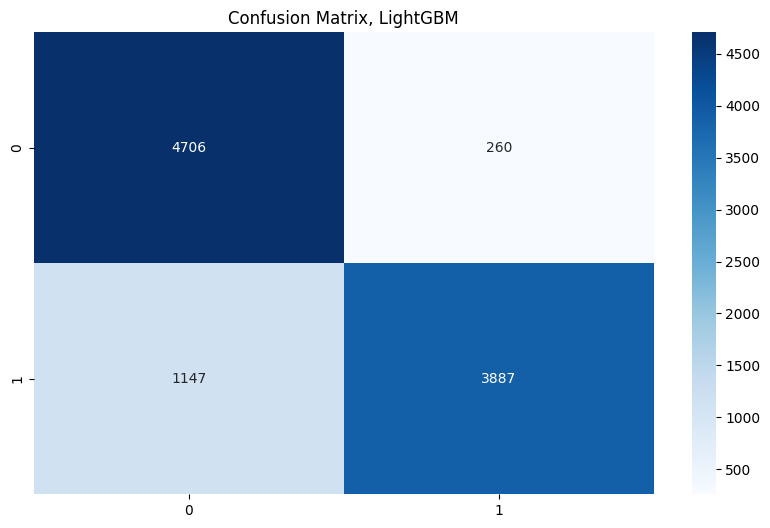

In [20]:
models = [dt, rf, svc, knn, nb, gb, ada, xgb, lgbm]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LightGBM']

for model, name in zip(models, model_names):
    print(model)
    train_model(model, tfidf_train, y_train, tfidf_test, name)
    

### DNN

In [21]:
tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()

neural_network = Sequential()
neural_network.add(Dense(64, input_dim=len(tfidf_features), activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(tfidf_train, y_train, epochs=50, batch_size=512, verbose=0)
_,test_acc = neural_network.evaluate(tfidf_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 3)))

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Acc. of DNN: 85.82 %


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4966
           1       0.93      0.78      0.85      5034

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

DNN Confusion Matrix:
[[4668  298]
 [1120 3914]]


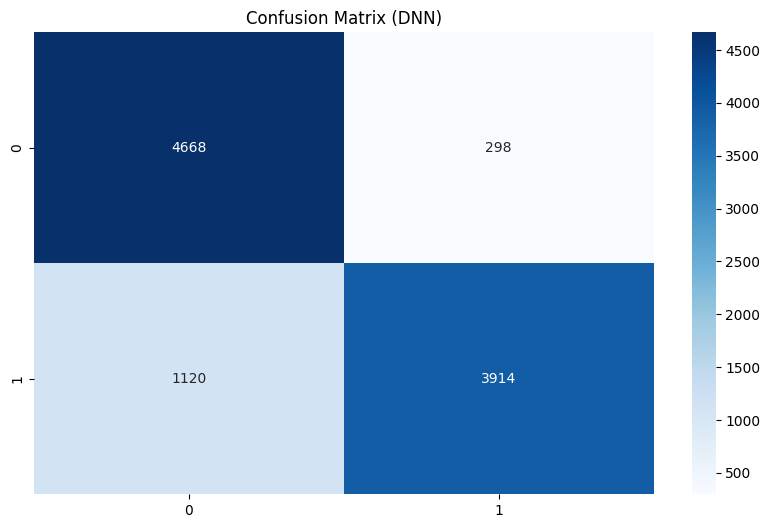

In [22]:
# confusion matrix of DNN
y_pred = (neural_network.predict(tfidf_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (DNN)')
plt.show()


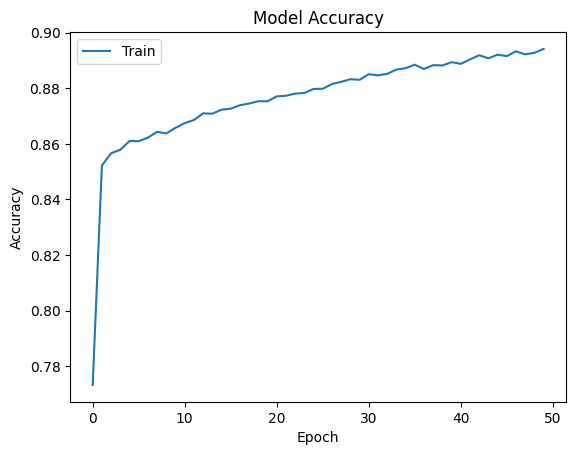

In [23]:
# visualize the model Accuracy-DNN

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

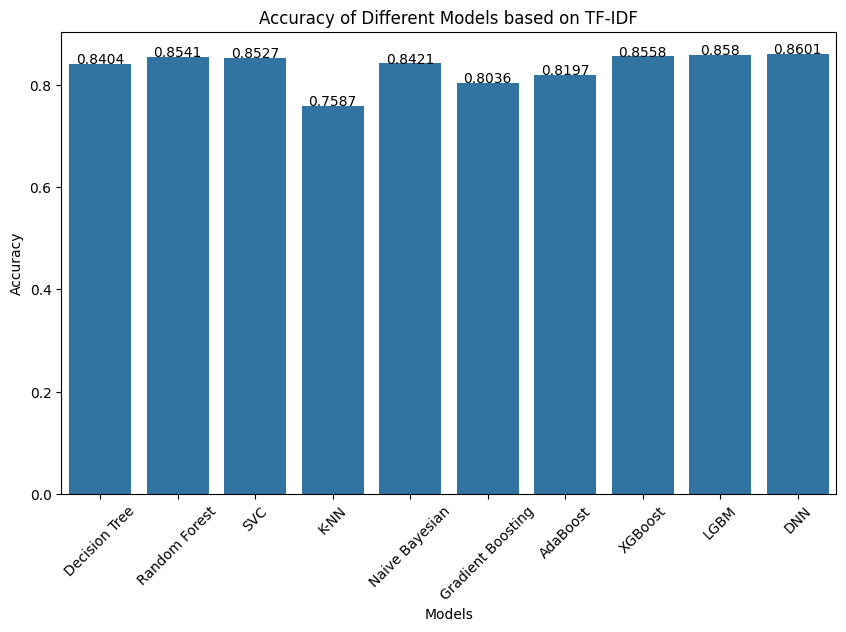

In [24]:
# visualize accuracy of different models

models = ['Decision Tree', 'Random Forest', 'SVC', 'K-NN', 'Naive Bayesian', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']
accuracy = [0.8404, 0.8541, 0.8527, 0.7587, 0.8421, 0.8036, 0.8197, 0.8558, 0.858, 0.8601]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy)
plt.title('Accuracy of Different Models based on TF-IDF')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for i in range(len(models)):
    plt.text(i, accuracy[i], accuracy[i], ha = 'center')
plt.show()

### improve with voting classifier
- hard voting

In [44]:
# Convert tfidf_train and tfidf_test to numpy arrays
tfidf_train_array = np.asarray(tfidf_train)
tfidf_test_array = np.asarray(tfidf_test)

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Hard Voting classifier
Accuracy:  0.8595
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      4966
           1       0.94      0.77      0.85      5034

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

Hard Voting Classifier Confusion Matrix:
[[4710  256]
 [1149 3885]]


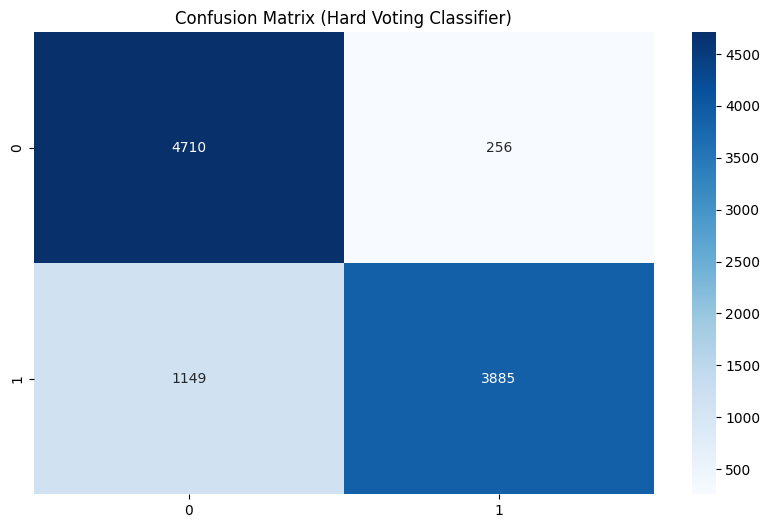

In [ ]:
# improve with voting classifier
from sklearn.ensemble import VotingClassifier

# Ensure individual classifiers are configured to use GPU if supported
xgb.set_params(tree_method='gpu_hist', predictor='gpu_predictor')
lgbm.set_params(device='gpu')

# hard voting classifier
hard_voting_clf = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('svc', svc), ('nb', nb), ('xgb', xgb), ('lgbm', lgbm)], 
    voting='hard', 
    n_jobs=-1  # Use all available CPU cores
)
hard_voting_clf.fit(tfidf_train_array, y_train)
y_pred = hard_voting_clf.predict(tfidf_test_array)
print("Hard Voting classifier")
print('Accuracy: ', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print("Hard Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Hard Voting Classifier)')
plt.show()

- soft voting

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [15:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [15:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the boo

Voting classifier
Accuracy:  0.8608
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      4967
           1       0.92      0.79      0.85      5033

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

Voting Classifier Confusion Matrix:
[[4611  356]
 [1036 3997]]


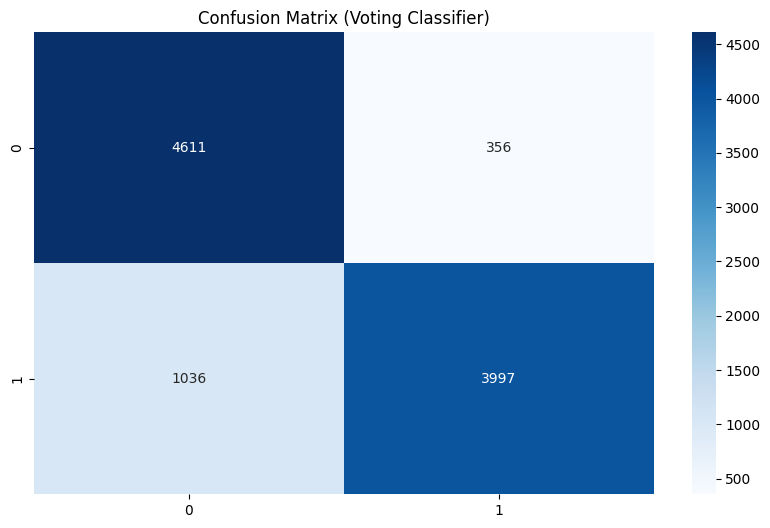

In [47]:
# soft voting classifier
from sklearn.ensemble import VotingClassifier
# drop bad models - KNN, Gradient Boosting, AdaBoost
voting_clf = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('svc', svc), ('nb', nb), ('xgb', xgb), ('lgbm', lgbm)], voting='soft', n_jobs=-1)

# Convert tfidf_train and tfidf_test to dense arrays
tfidf_train_array = tfidf_train.toarray()
tfidf_test_array = tfidf_test.toarray()

voting_clf.fit(tfidf_train_array, y_train)
y_pred = voting_clf.predict(tfidf_test_array)
print("Voting classifier")
print('Accuracy: ', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print("Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Voting Classifier)')
plt.show()

## Construct model use counter vectorizer

### vectorize

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['headline_text'])

# transform the training and validation data using count vectorizer object
xtrain_count = count_vect.transform(x_train).astype(np.float64)
xvalid_count = count_vect.transform(x_test).astype(np.float64)

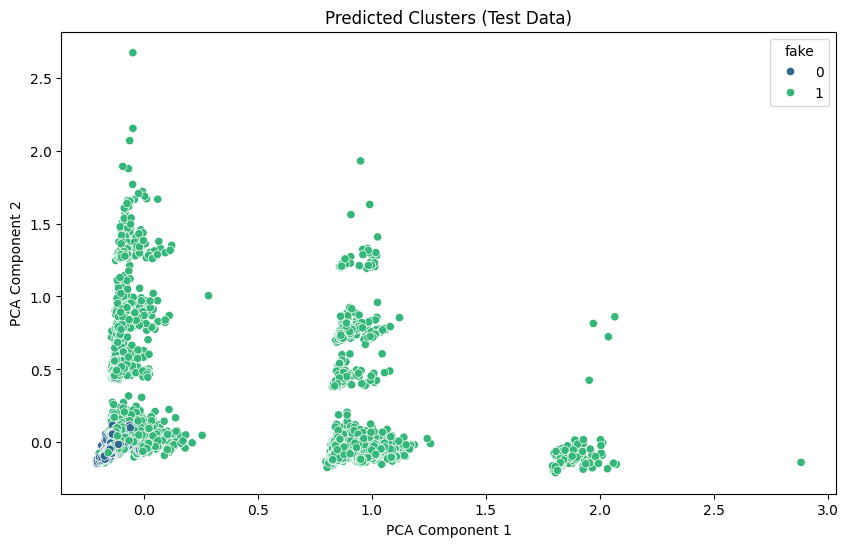

In [49]:
# visualize the classified results with labels
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=2)
train_pca = pca.fit_transform(xtrain_count)
test_pca = pca.transform(xvalid_count)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_pca[:,0], y=train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Predicted Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

### basic models

DecisionTreeClassifier()
Accuracy:  0.8812
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88      4967
         1.0       0.85      0.92      0.89      5033

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

[[4162  805]
 [ 383 4650]]


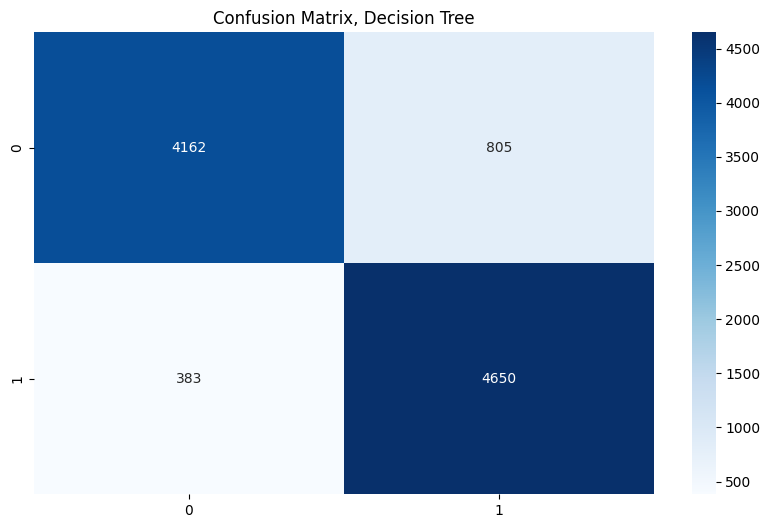

RandomForestClassifier(n_jobs=-1)
Accuracy:  0.9114
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      4967
         1.0       0.89      0.93      0.91      5033

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

[[4415  552]
 [ 334 4699]]


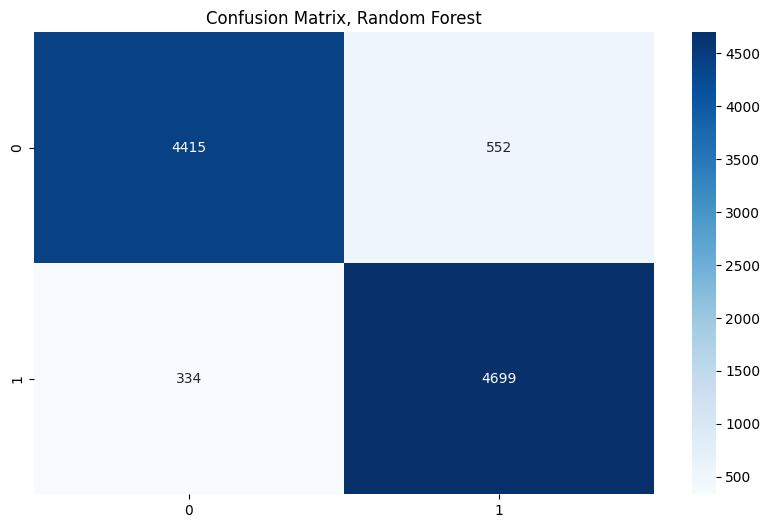

SVC(kernel='linear', probability=True)
Accuracy:  0.9377
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      4967
         1.0       0.96      0.92      0.94      5033

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

[[4754  213]
 [ 410 4623]]


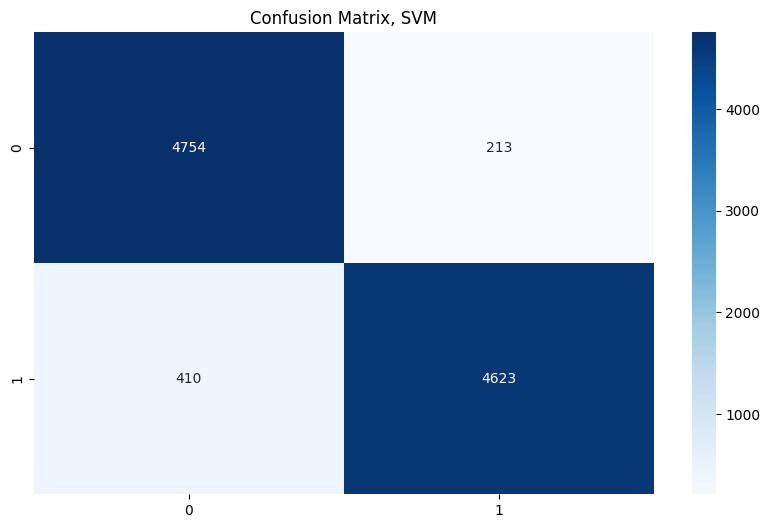

KNeighborsClassifier(n_jobs=-1)
Accuracy:  0.5655
              precision    recall  f1-score   support

         0.0       0.92      0.14      0.24      4967
         1.0       0.54      0.99      0.70      5033

    accuracy                           0.57     10000
   macro avg       0.73      0.56      0.47     10000
weighted avg       0.73      0.57      0.47     10000

[[ 685 4282]
 [  63 4970]]


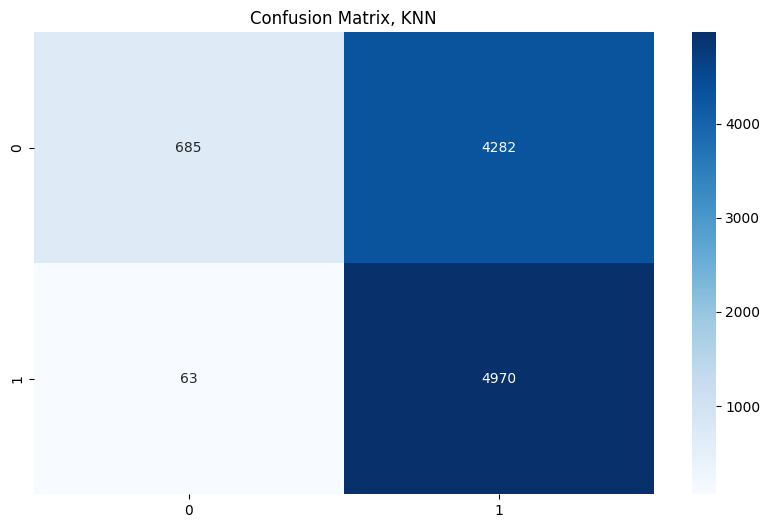

MultinomialNB()
Accuracy:  0.943
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      4967
         1.0       0.95      0.93      0.94      5033

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

[[4737  230]
 [ 340 4693]]


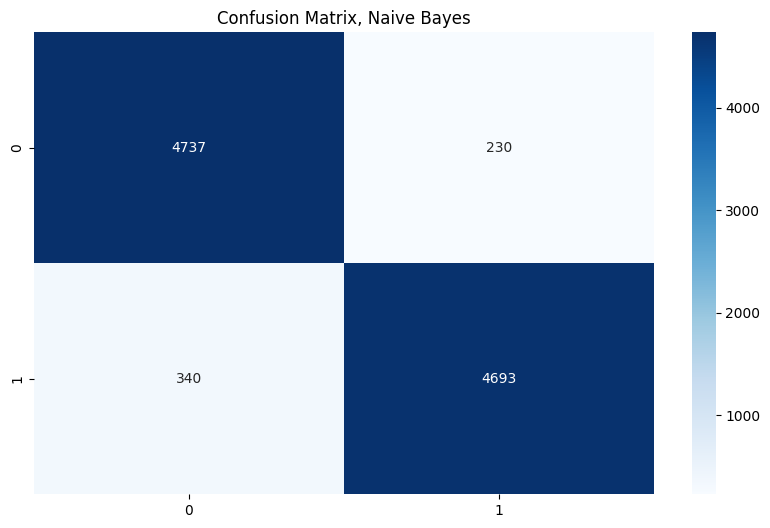

GradientBoostingClassifier()
Accuracy:  0.8096
              precision    recall  f1-score   support

         0.0       0.73      0.98      0.84      4967
         1.0       0.97      0.64      0.77      5033

    accuracy                           0.81     10000
   macro avg       0.85      0.81      0.80     10000
weighted avg       0.85      0.81      0.80     10000

[[4884   83]
 [1821 3212]]


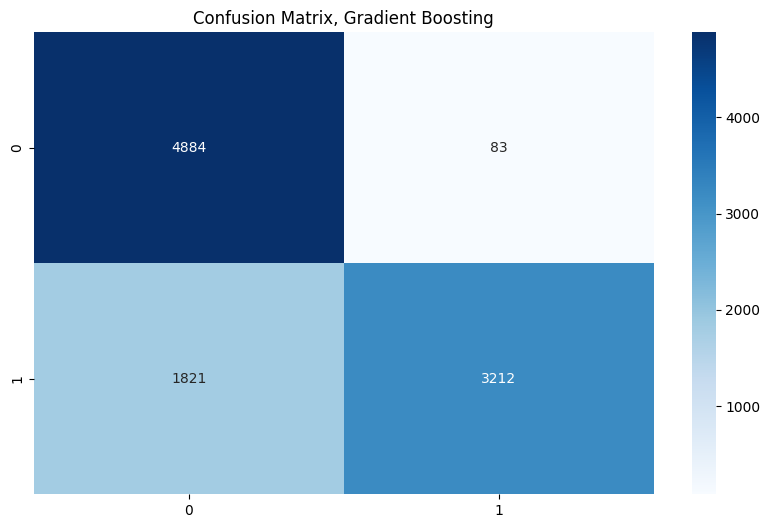

AdaBoostClassifier()


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.8224
              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84      4967
         1.0       0.95      0.68      0.79      5033

    accuracy                           0.82     10000
   macro avg       0.85      0.82      0.82     10000
weighted avg       0.85      0.82      0.82     10000

[[4784  183]
 [1593 3440]]


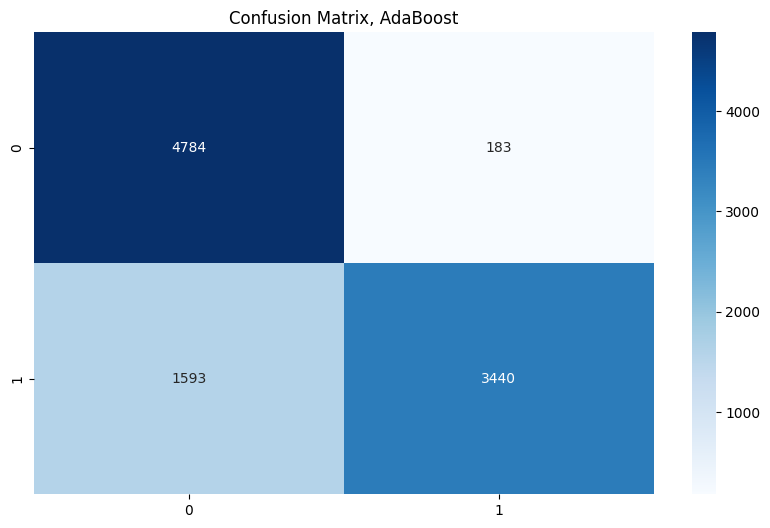

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, predictor='gpu_predictor', ...)


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [15:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [15:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [15:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c

Accuracy:  0.881
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      4967
         1.0       0.97      0.79      0.87      5033

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

[[4840  127]
 [1063 3970]]


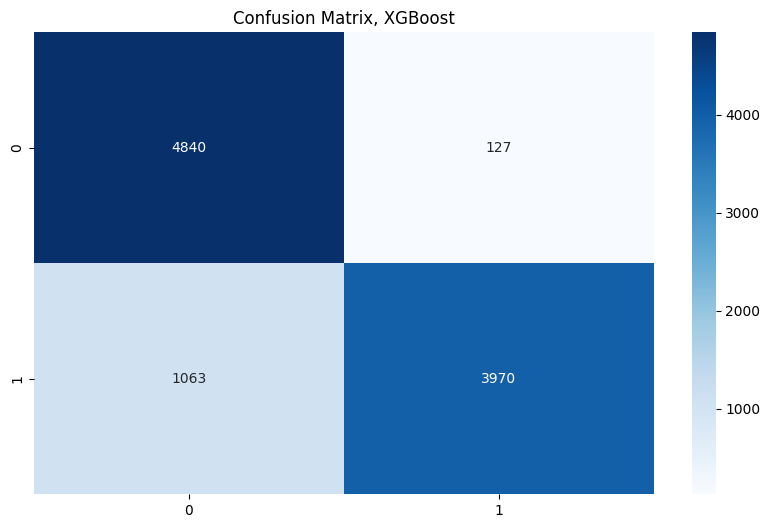

LGBMClassifier(device='gpu')
[LightGBM] [Info] Number of positive: 19967, number of negative: 20033
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5186
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 2278
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499175 -> initscore=-0.003300
[LightGBM] [Info] Start training from score -0.003300
Accuracy:  0.8957
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      4967
         1.0       0.96      0.82      0.89      5033

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     1

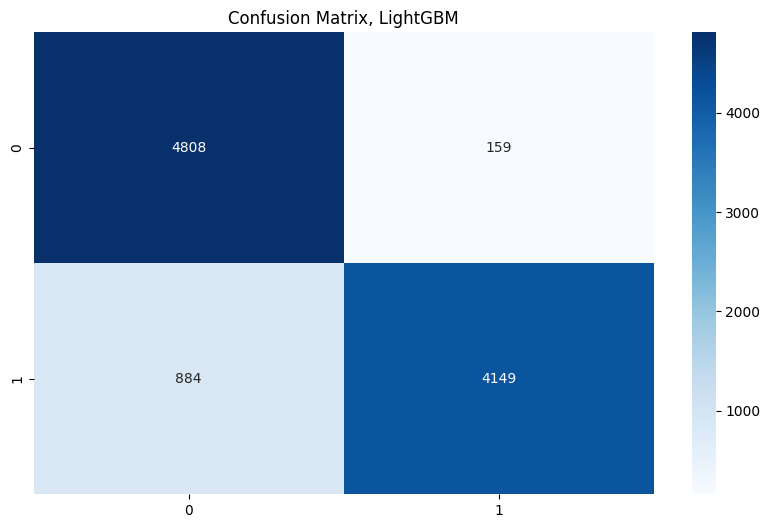

In [50]:
# Convert labels to np.float64
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# # Convert tfidf_train and tfidf_test to numpy arrays
# tfidf_train_array = np.asarray(tfidf_train)
# tfidf_test_array = np.asarray(tfidf_test)

models = [dt, rf, svc, knn, nb, gb, ada, xgb, lgbm]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LightGBM']

# Count Vectors
for model, modelnames in zip(models, model_names):
    print(model)
    train_model(model, xtrain_count, y_train, xvalid_count, modelnames)
    


### DNN

Testing Acc. of DNN: 93.37 %
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
DNN Confusion Matrix:
[[4647  320]
 [ 343 4690]]


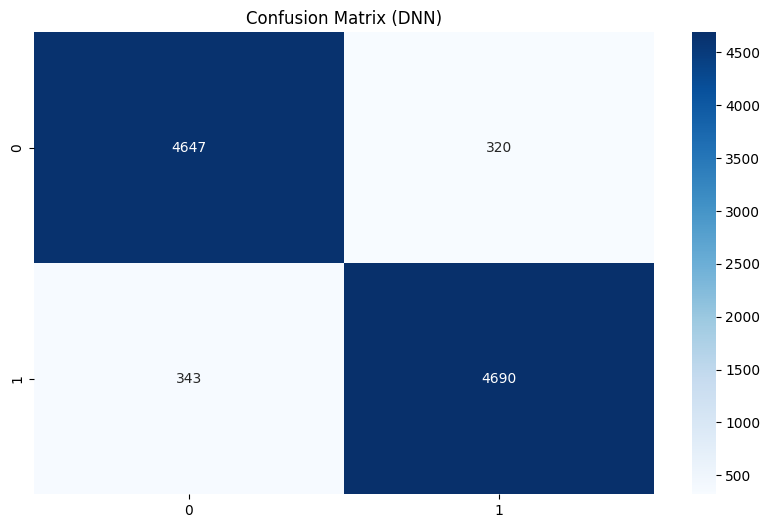

In [ ]:
# DNN
from keras.layers import Input # type: ignore
from keras.models import Model
from keras.layers import Dense, Dropout

input_layer = Input(shape=(xtrain_count.shape[1],), sparse=True)
dense_layer_1 = Dense(64, activation='relu')(input_layer)
dropout_layer_1 = Dropout(0.1)(dense_layer_1)
dense_layer_2 = Dense(64, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.1)(dense_layer_2)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_2)

neural_network = Model(inputs=input_layer, outputs=output_layer)
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(xtrain_count, y_train, epochs=50, batch_size=512, verbose=0)
_, test_acc = neural_network.evaluate(xvalid_count, y_test, verbose=0)
print("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 3)))

# confusion matrix of DNN
y_pred = (neural_network.predict(xvalid_count) > 0.5).astype("int32")
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (DNN)')
plt.show()


              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      4967
         1.0       0.94      0.93      0.93      5033

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

DNN Confusion Matrix:
[[4647  320]
 [ 343 4690]]


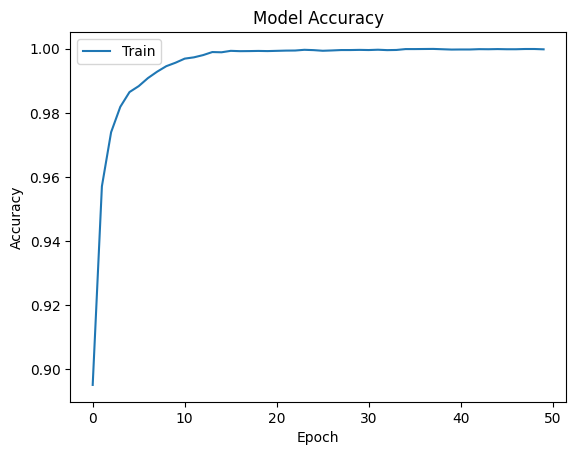

In [53]:
print(classification_report(y_test, y_pred))
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# visualize the model Accuracy-DNN
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

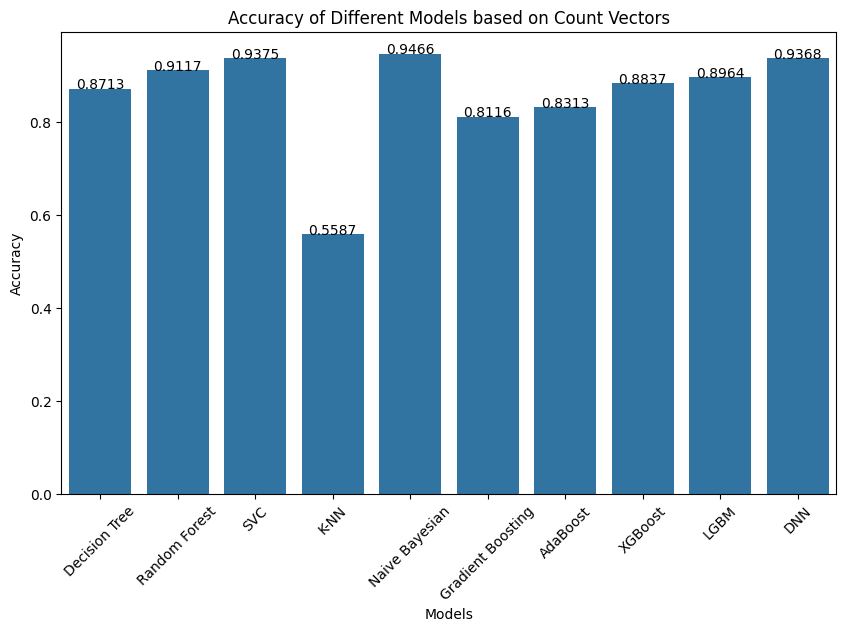

In [54]:
# visualize accuracy of different models

models = ['Decision Tree', 'Random Forest', 'SVC', 'K-NN', 'Naive Bayesian', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']
accuracy = [0.8713, 0.9117, 0.9375, 0.5587, 0.9466, 0.8116, 0.8313, 0.8837, 0.8964, 0.9368]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy)
plt.title('Accuracy of Different Models based on Count Vectors')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for i in range(len(models)):
    plt.text(i, accuracy[i], accuracy[i], ha = 'center')
plt.show()


### voting

In [55]:
# hard voting classifier
hard_voting_clf = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('svc', svc), ('nb', nb), ('xgb', xgb), ('lgbm', lgbm)], voting='hard',n_jobs=-1)
hard_voting_clf.fit(np.asarray(xtrain_count.todense()), y_train)
y_pred = hard_voting_clf.predict(np.asarray(xvalid_count.todense()))
print("Hard Voting classifier")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Hard Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Hard Voting Classifier)')
plt.show()

: 

In [24]:
xtrain_count.shape, xvalid_count.shape

((40000, 17785), (10000, 17785))

In [ ]:
# soft voting classifier
# drop bad models - KNN, Gradient Boosting, AdaBoost
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('svc', svc), ('nb', nb), ('xgb', xgb), ('lgbm', lgbm)], voting='soft')
print("Voting classifier finished")
voting_clf.fit(np.asarray(xtrain_count.todense()), y_train)
print("Voting classifier fit finished")
y_pred = voting_clf.predict(np.asarray(xvalid_count.todense()))
print("Voting classifier prediction finished")
print("Voting classifier")
print('Accuracy: ', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print("Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


## Construct models use word2vec

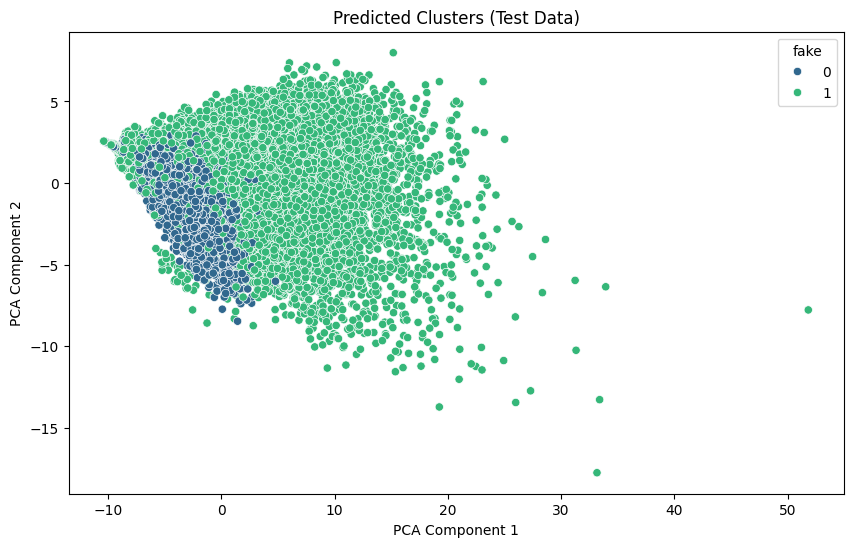

In [35]:
# construct models use word2vec
from gensim.models import Word2Vec
from gensim import utils
from sklearn.feature_extraction.text import TfidfVectorizer

# create a word2vec model
word2vec = Word2Vec([headline.split() for headline in train['headline_text']], vector_size=300, window=5, min_count=1, sg=1)

# create a vectorizer object
# tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
# tfidf_train = tfidf_vectorizer.fit_transform(x_train)
# tfidf_test = tfidf_vectorizer.transform(x_test)
# tfidf_features = tfidf_vectorizer.get_feature_names_out()

# create a function to get the vector of a sentence
def get_vector(sentence):
    vector = np.zeros(300)
    for word in sentence.split():
        try:
            vector += word2vec.wv[word]
        except:
            pass
    return vector

# create a function to get the vectors of a dataset
def get_vectors(data):
    vectors = []
    for sentence in data:
        vectors.append(get_vector(sentence))
    return np.array(vectors)

# get the vectors of the training and validation datasets
word2vec_train = get_vectors(x_train)
word2vec_test = get_vectors(x_test)

# visualize the classified results with labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
train_pca = pca.fit_transform(word2vec_train)
test_pca = pca.transform(word2vec_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_pca[:,0], y=train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Predicted Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

### run model

DecisionTreeClassifier()
Accuracy:  0.8659
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5099
           1       0.86      0.87      0.86      4901

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

[[4375  724]
 [ 617 4284]]


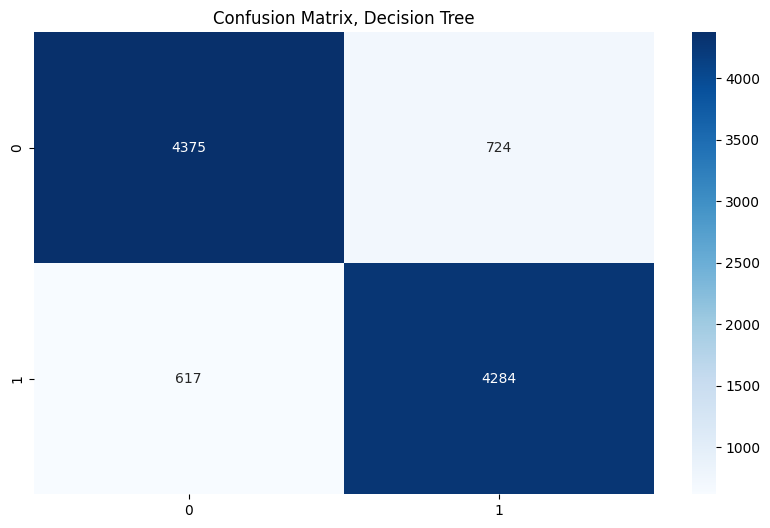

RandomForestClassifier()
Accuracy:  0.9175
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      5099
           1       0.94      0.89      0.91      4901

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[4830  269]
 [ 556 4345]]


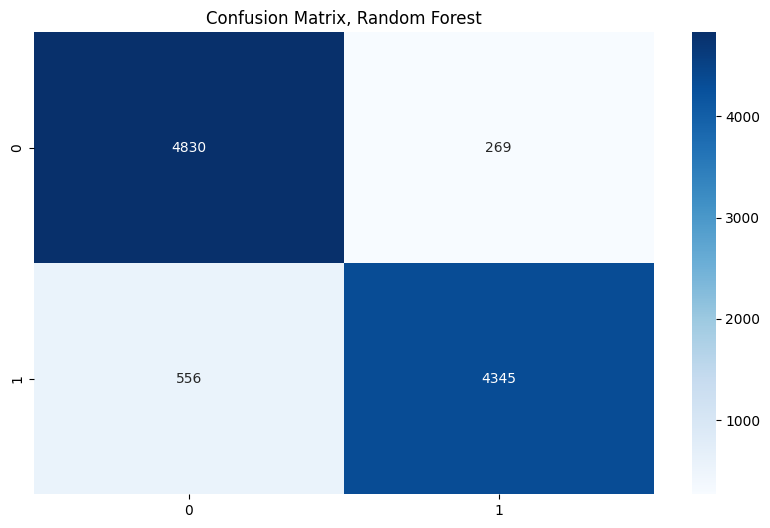

SVC(kernel='linear', probability=True)
Accuracy:  0.9016
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5099
           1       0.95      0.85      0.89      4901

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

[[4871  228]
 [ 756 4145]]


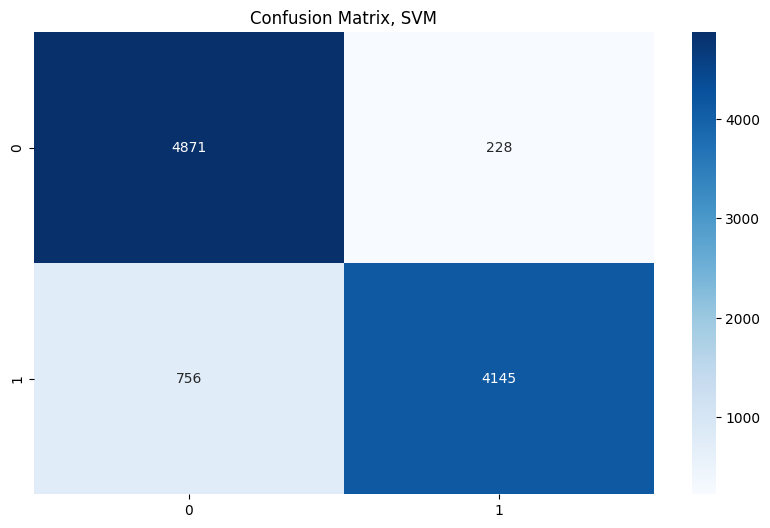

KNeighborsClassifier()
Accuracy:  0.9062
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5099
           1       0.93      0.88      0.90      4901

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

[[4757  342]
 [ 596 4305]]


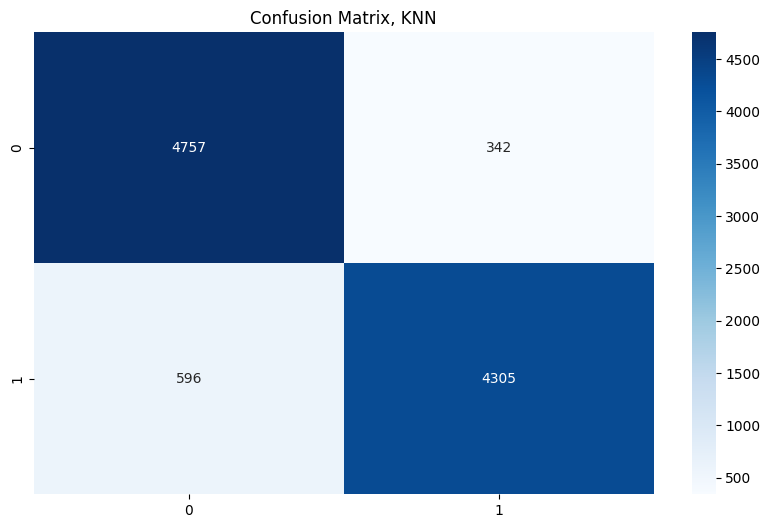

GaussianNB()
Accuracy:  0.8297
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      5099
           1       0.89      0.74      0.81      4901

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

[[4661  438]
 [1265 3636]]


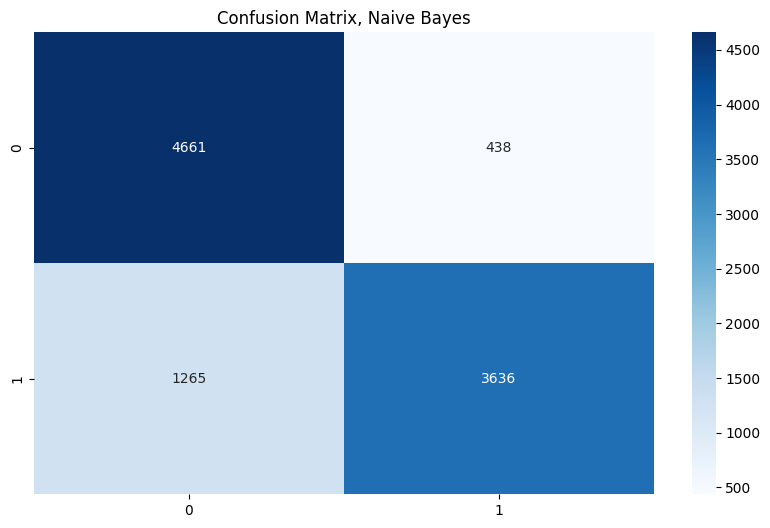

GradientBoostingClassifier()
Accuracy:  0.9091
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5099
           1       0.93      0.88      0.90      4901

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

[[4793  306]
 [ 603 4298]]


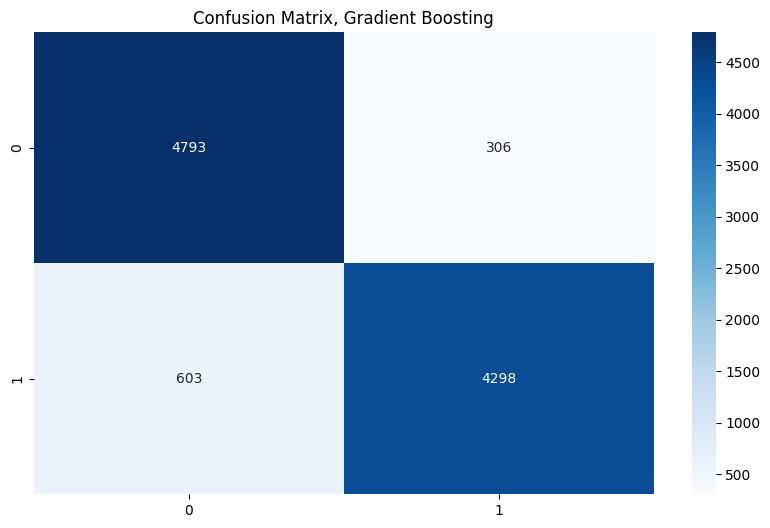

AdaBoostClassifier()


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.8961
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5099
           1       0.92      0.86      0.89      4901

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[4753  346]
 [ 693 4208]]


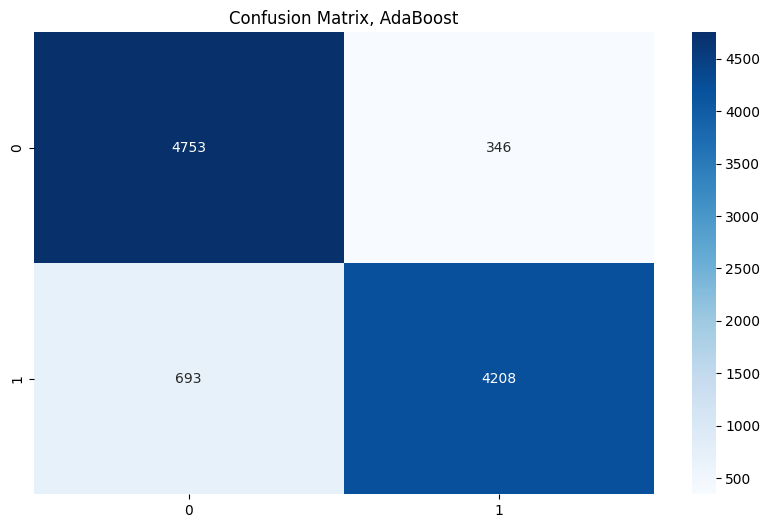

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy:  0.9201
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5099
           1       0.93      0.90      0.92      4901

    accuracy                           0.92     10000
   mac

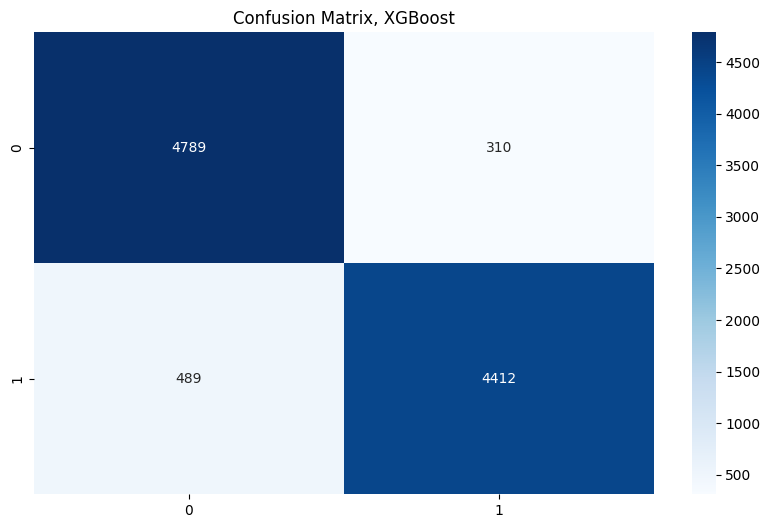

LGBMClassifier()
[LightGBM] [Info] Number of positive: 20099, number of negative: 19901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502475 -> initscore=0.009900
[LightGBM] [Info] Start training from score 0.009900
Accuracy:  0.9178
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5099
           1       0.94      0.89      0.91      4901

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[4812  287]
 [ 535 4366]]


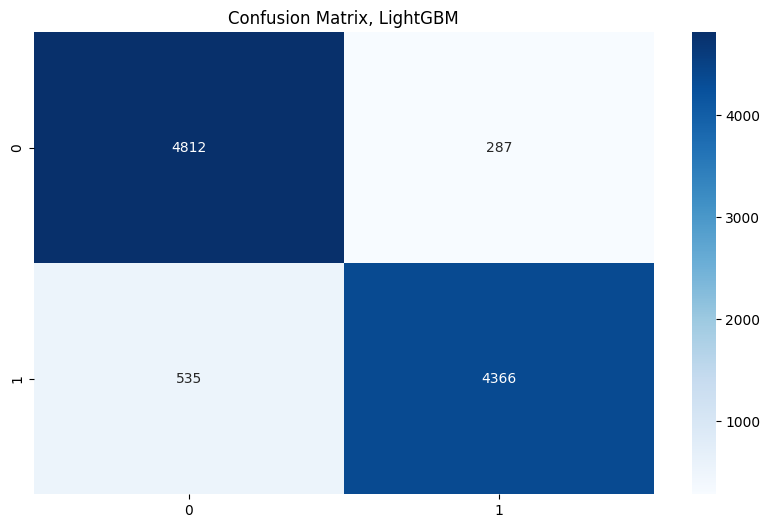

In [39]:
# construct models use word2vec

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

gaussiannb = GaussianNB()
models = [dt, rf, svc, knn, gaussiannb, gb, ada, xgb, lgbm]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LightGBM']

# Count Vectors
for model, modelnames in zip(models, model_names):
    print(model)
    train_model(model, word2vec_train, y_train, word2vec_test, modelnames)

In [40]:
# DNN
neural_network = Sequential()
neural_network.add(Dense(64, input_dim=300, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))

neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(word2vec_train, y_train, epochs=50, batch_size=512, verbose=0)
_,test_acc = neural_network.evaluate(word2vec_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 3)))

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Acc. of DNN: 92.11 %


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5099
           1       0.93      0.91      0.92      4901

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

DNN Confusion Matrix:
[[4768  331]
 [ 458 4443]]


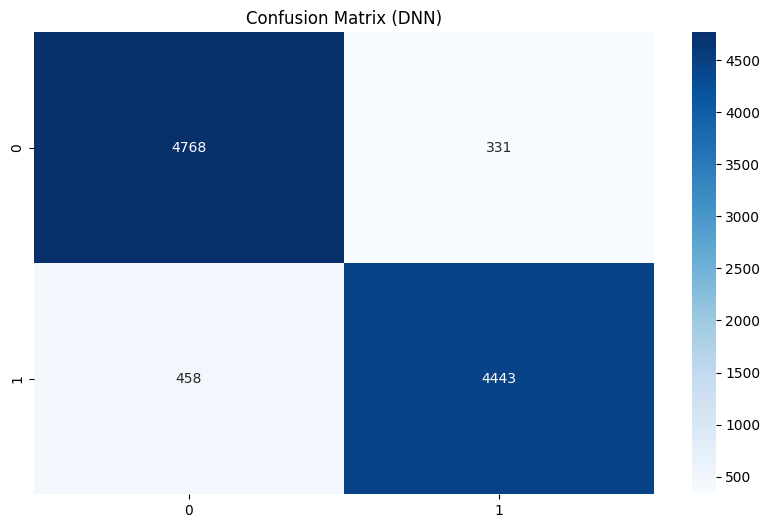

In [41]:
# confusion matrix of DNN
y_pred = (neural_network.predict(word2vec_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (DNN)')
plt.show()

### accuracy

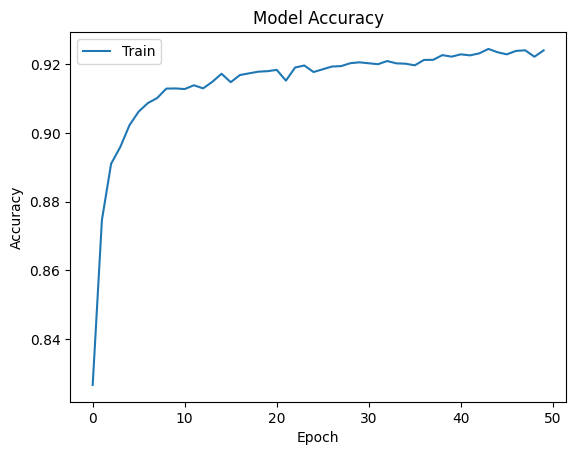

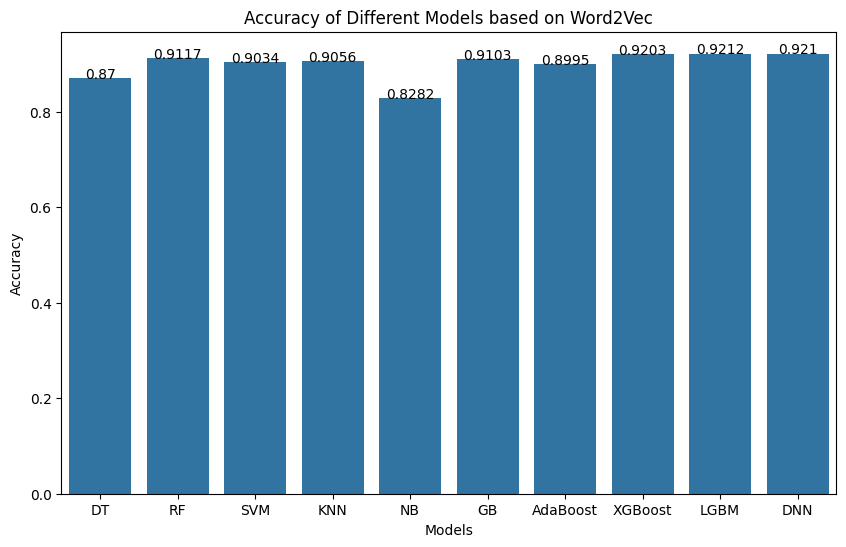

In [42]:
# visualize the model Accuracy-DNN
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# visualize accuracy of different models

models = ['DT', 'RF', 'SVM', 'KNN', 'NB', 'GB', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']
accuracy = [0.87, 0.9117, 0.9034, 0.9056, 0.8282, 0.9103, 0.8995, 0.9203, 0.9212, 0.9210]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy)
plt.title('Accuracy of Different Models based on Word2Vec')
plt.xlabel('Models')
plt.ylabel('Accuracy')
for i in range(len(models)):
    plt.text(i, accuracy[i], accuracy[i], ha = 'center')
plt.show()


In [43]:
word2vec_train.shape, word2vec_test.shape

((40000, 300), (10000, 300))

### voting

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure individual classifiers are configured to use GPU if supported
# Example for XGBoost and LightGBM:
xgb.set_params(tree_method='gpu_hist', predictor='gpu_predictor')
lgbm.set_params(device='gpu')

# Hard voting classifier with parallel processing
hard_voting_clf = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('svc', svc), ('nb', gaussiannb), ('xgb', xgb), ('lgbm', lgbm)],
    voting='hard',
    n_jobs=-1  # Use all available CPU cores
)

# Fit the classifier
hard_voting_clf.fit(word2vec_train, y_train)

# Predict
y_pred = hard_voting_clf.predict(word2vec_test)

# Evaluation
print("Hard Voting classifier")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Hard Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Hard Voting Classifier)')
plt.show()

: 

In [ ]:
# soft voting classifier
# drop bad models - KNN, Gradient Boosting, AdaBoost
voting_clf = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('svc', svc), ('nb', gaussiannb), ('xgb', xgb), ('lgbm', lgbm)], voting='soft')
voting_clf.fit(word2vec_train, y_train)
y_pred = voting_clf.predict(word2vec_test)
print("Voting classifier")
print('Accuracy: ', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print("Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


## Comparison

<Figure size 1200x600 with 0 Axes>

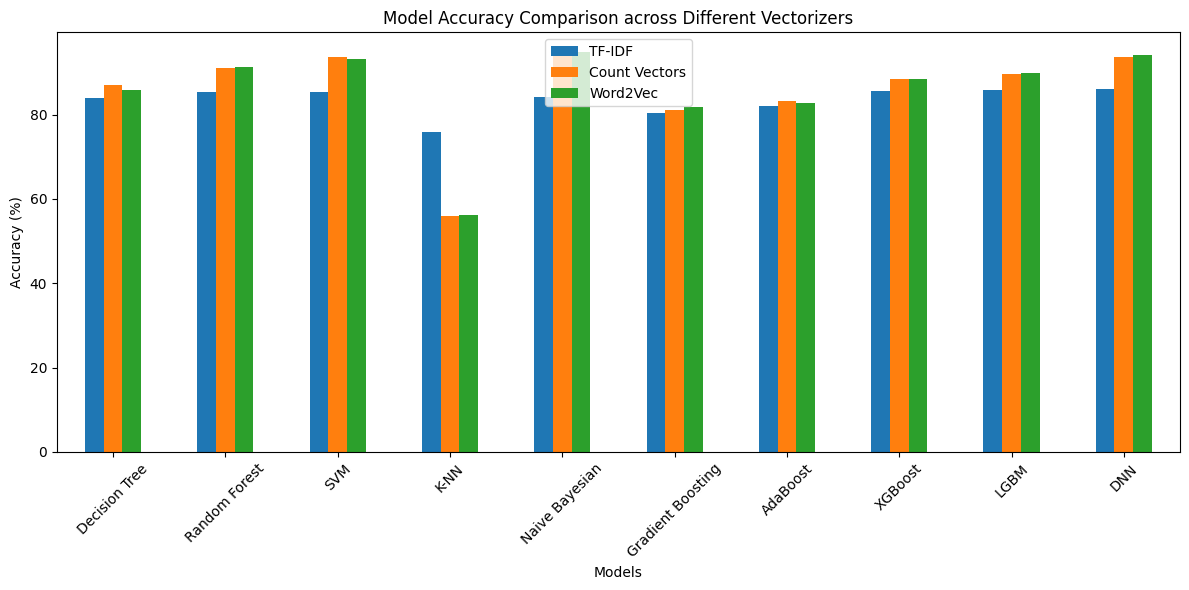

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model names
models = ['Decision Tree', 'Random Forest', 'SVM', 'K-NN', 'Naive Bayesian', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']

# Accuracy values for TF-IDF, Count Vectors, and Word2Vec
accuracy_tfidf = [84.04, 85.41, 85.27, 75.87, 84.21, 80.36, 81.97, 85.58, 85.80, 86.01]
accuracy_count = [87.13, 91.17, 93.75, 55.87, 94.66, 81.16, 83.13, 88.37, 89.64, 93.68]
accuracy_word2vec = [85.87, 91.32, 93.25, 56.22, 94.78, 81.91, 82.68, 88.46, 89.92, 94.21]

# Dataframe for plotting
accuracy_data = {
    'Models': models,
    'TF-IDF': accuracy_tfidf,
    'Count Vectors': accuracy_count,
    'Word2Vec': accuracy_word2vec
}

# Plotting
plt.figure(figsize=(12, 6))
df = pd.DataFrame(accuracy_data)
df.set_index('Models', inplace=True)
df.plot(kind='bar', figsize=(12, 6))

plt.title('Model Accuracy Comparison across Different Vectorizers')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
